# Basic unet
This is a bare bone U-net for some experiments with transfer learning

## Import libraries

In [375]:
import os
import imageio.v2 as imageio
from skimage.transform import resize # For preprocessing
import tensorflow as tf
tf.keras.utils.set_random_seed(0)

## Read data from disk

In [543]:
%%time

IMG_WIDTH = 256 
IMG_HEIGHT = 256
IMG_CHANNELS = 1 # a grey scale image only has one band for color.
NUM_CLASSES = 1 # 0 = no crater and 1 = crater

#### Training data ####
TRAIN_PATH = '/workspace/data/final_data_1m/training/'
IMG_DIR = 'hillshade'
GT_DIR = 'labels'
X_train_pit = []
Y_train_pit = []

# load from disk
img_path = os.path.join(TRAIN_PATH, IMG_DIR)
gt_path = os.path.join(TRAIN_PATH, GT_DIR)
for image in (os.listdir(img_path)):
    img = imageio.imread(os.path.join(img_path, image))

    img = resize(img, (IMG_WIDTH, IMG_HEIGHT,1), mode='constant', preserve_range=True)
    
    mask = imageio.imread(os.path.join(gt_path, image))
    mask = resize(mask, (IMG_WIDTH, IMG_HEIGHT, 1), preserve_range=True, order=0).astype(int)
    
    X_train_pit.append(img)
    Y_train_pit.append(mask)

#### Test data ####
TEST_PATH = '/workspace/data/final_data_1m/testing/'
IMG_DIR = 'hillshade'
GT_DIR = 'labels'
X_test_pit = []
Y_test_pit = []

# load from disk
img_path = os.path.join(TEST_PATH, IMG_DIR)
gt_path = os.path.join(TEST_PATH, GT_DIR)
for image in (os.listdir(img_path)):
    img = imageio.imread(os.path.join(img_path, image))
    img = resize(img, (IMG_WIDTH, IMG_HEIGHT,1), mode='constant', preserve_range=True)
    mask = imageio.imread(os.path.join(gt_path, image))
    mask = resize(mask, (IMG_WIDTH, IMG_HEIGHT, 1), preserve_range=True, order=0).astype(int)
    
    X_test_pit.append(img)
    Y_test_pit.append(mask)

# convert list of numpy arrays into tensorflow dataset for further processing
train_images_pit = tf.data.Dataset.from_tensor_slices((X_train_pit, Y_train_pit))
test_images_pit = tf.data.Dataset.from_tensor_slices((X_test_pit, Y_test_pit))

CPU times: user 2min 2s, sys: 846 ms, total: 2min 2s
Wall time: 2min 16s


In [549]:
print('number of chips: ',len(train_images_pit))

steps_per_epoch = round((len(train_images_pit)) / BATCH_SIZE)
print('steps_per_epoch: ',steps_per_epoch)

number of chips:  827
steps_per_epoch:  52


## Set up pipelines to preload data

In [544]:
BATCH_SIZE = 16
BUFFER_SIZE = 128

# training
train_batches_pit  = (train_images_pit 
                    .cache() # cache data
                    .shuffle(BUFFER_SIZE) # fill buffer, sample from it and replace with new items (buffer size > training set for perfect shuffling)
                    .batch(BATCH_SIZE)  
                    .repeat() 
                    .prefetch(buffer_size=128))
# testing
test_batches_pit  = (test_images_pit  
                    .cache() # cache data
                    .shuffle(BUFFER_SIZE) # fill buffer, sample from it and replace with new items (buffer size > training set for perfect shuffling)
                    .batch(BATCH_SIZE)  
                    .repeat(1)  # repeat dataset idefinetely
                    .prefetch(buffer_size=128)) 


## Add f1-score as a metric to monitor

In [545]:
from keras import backend as K
from sklearn.metrics import matthews_corrcoef

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


## Basic U-net

In [546]:
#Build the model
tf.keras.utils.set_random_seed(2)
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
NUM_CLASSES = 1

#Contraction path
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1) # to prevent overfitting
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(NUM_CLASSES, (1, 1))(c9)

model_pit = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model_pit.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, from_logits=True), metrics=['acc', f1_m, recall_m])

## Train the model

In [550]:
%%time
result1 = model_pit.fit(train_batches_pit,validation_data=test_batches_pit, epochs=100, steps_per_epoch=steps_per_epoch)

Epoch 1/100
52/52 [==============================] - 4s 80ms/step - loss: 3.4470e-04 - acc: 0.9999 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.0953e-04 - val_acc: 1.0000 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
52/52 [==============================] - 4s 80ms/step - loss: 3.2952e-04 - acc: 0.9999 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.1923e-04 - val_acc: 1.0000 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/100
52/52 [==============================] - 4s 80ms/step - loss: 3.3182e-04 - acc: 0.9999 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.9984e-04 - val_acc: 1.0000 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/100
52/52 [==============================] - 4s 81ms/step - loss: 3.2366e-04 - acc: 0.9999 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.2401e-04 - val_acc: 1.0000 - val_f1_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 5/100
52/52 [==============================] - 4s 81ms/step - loss

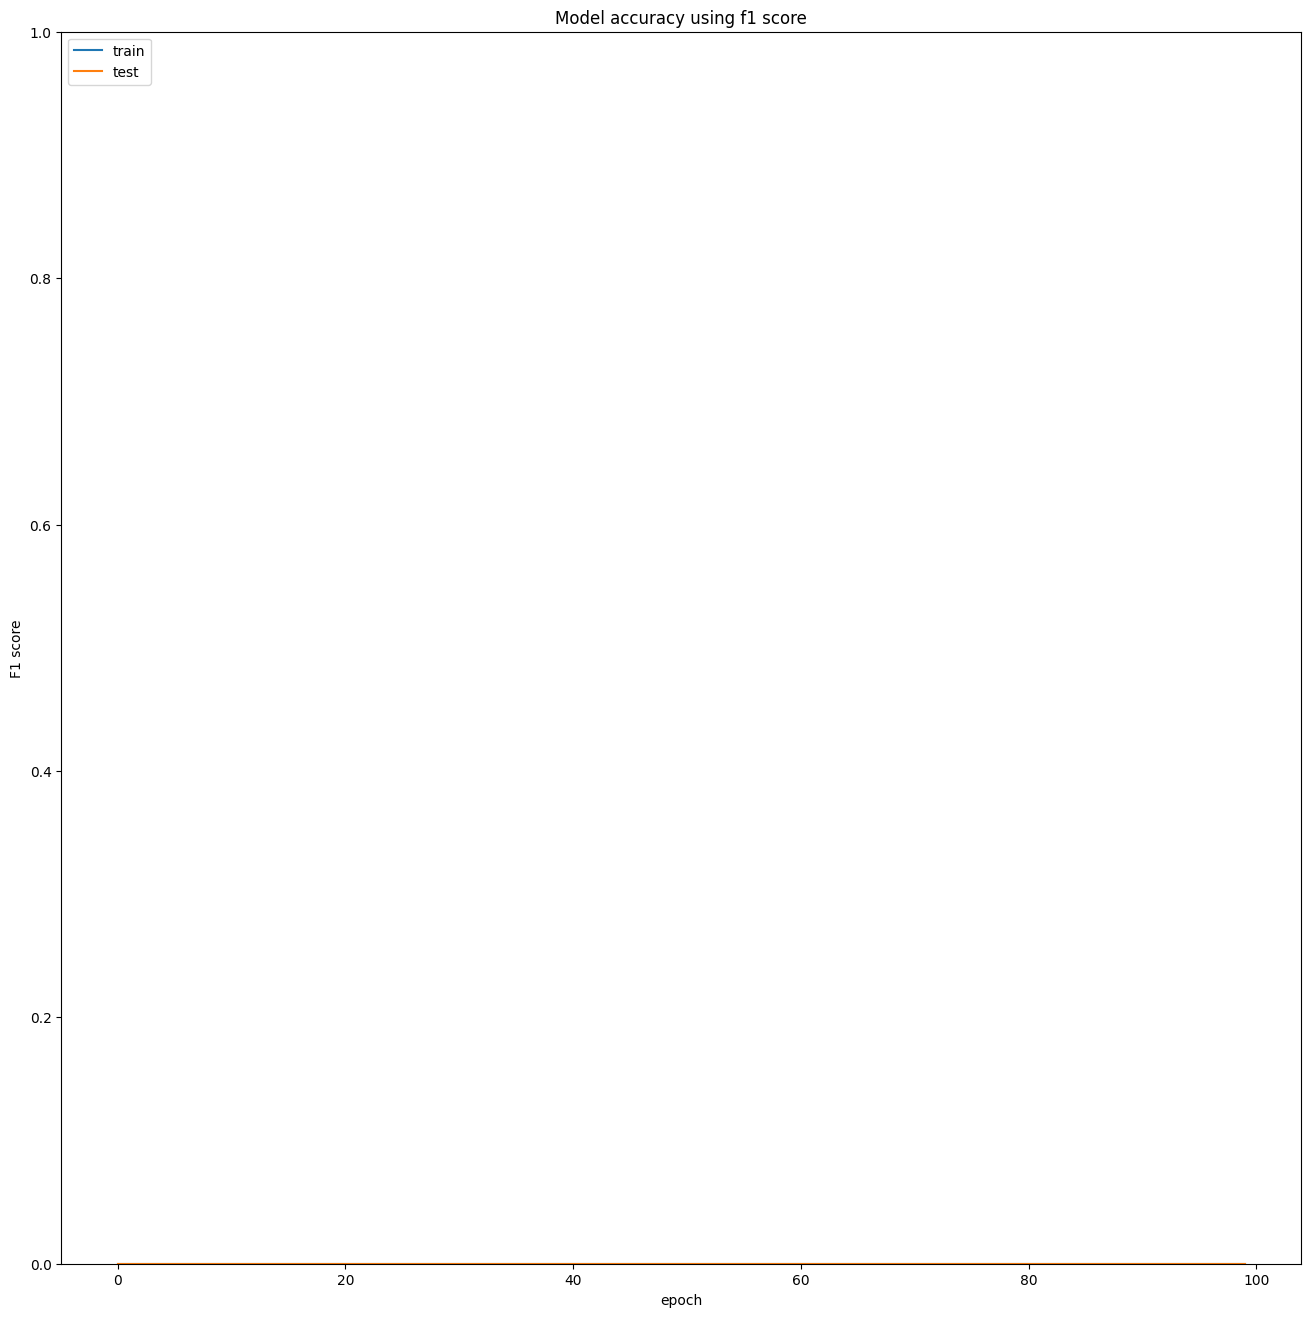

In [551]:
# summarize history for accuracy
import matplotlib.pyplot as plt
#plt.plot(result.history['f1_m'])
#plt.plot(result.history['val_f1_m'])
plt.plot(result1.history['f1_m'])
plt.plot(result1.history['val_f1_m'])
plt.title('Model accuracy using f1 score')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [552]:
results = model_pit.evaluate(test_batches_pit)

13/13 [==============================] - 0s 21ms/step - loss: 1.9431e-04 - acc: 1.0000 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00


1/1 [==============================] - 0s 20ms/step


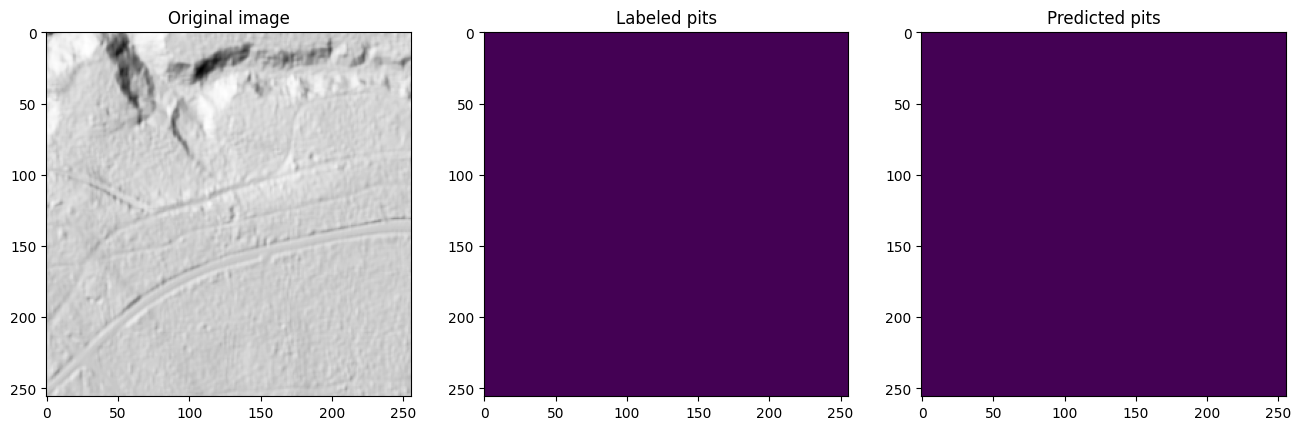

In [559]:
# size of plot
import numpy as np
import random
plt.rcParams['figure.figsize'] = [16, 16]
f, axarr = plt.subplots(1,3)
i = random.randint(0, 300)
#i = 14
#image 
testimage = X_test_pit[i]
orgimage = np.squeeze(testimage)

# label
testlabel = Y_test_pit[i]
testlabel = np.squeeze(testlabel)

# prediction
testimage = X_test_pit[i]
testimage = np.reshape(testimage,[1,256,256,1])
prediction_pit = model_pit.predict(testimage)
pred_pit = np.squeeze(prediction_pit)


# Image
axarr[0].set_title('Original image')
axarr[0].imshow(orgimage, cmap='Greys_r')

# Label
axarr[1].set_title('Labeled pits')
axarr[1].imshow(testlabel)

# Prediction
axarr[2].set_title('Predicted pits')
axarr[2].imshow(pred_pit>0.5)

# Train a model on the moon

In [489]:
#!pip install imagecodecs
import imagecodecs

In [516]:
%%time
import os
import imageio.v2 as imageio
#import tifffile
#import imagecodecs
from skimage.transform import resize # For preprocessing
import tensorflow as tf
tf.keras.utils.set_random_seed(0)



IMG_WIDTH = 256 # nr pixels
IMG_HEIGHT = 256
IMG_CHANNELS = 1 # a grey scale image only has one band for color.
NUM_CLASSES = 1 # 0 = no crater and 1 = crater

#### Training data ####
#TRAIN_PATH = '/workspace/data/lunar_data/final_data/training/'
TRAIN_PATH = '/workspace/data/lunar_data/split_data/'
IMG_DIR = 'hillshade2'
GT_DIR = 'labels'
X_train = []
Y_train = []

# load from disk
img_path = os.path.join(TRAIN_PATH, IMG_DIR)
gt_path = os.path.join(TRAIN_PATH, GT_DIR)
for image in (os.listdir(img_path)):

    img = imageio.imread(os.path.join(img_path, image))
    #img = tifffile.imread(os.path.join(img_path, image))

    img = resize(img, (IMG_WIDTH, IMG_HEIGHT,1), mode='constant', preserve_range=True)
    mask = imageio.imread(os.path.join(gt_path, image))
    #mask = tifffile.imread(os.path.join(gt_path, image))
    mask = resize(mask, (IMG_WIDTH, IMG_HEIGHT, 1), preserve_range=True, order=0).astype(int)

    X_train.append(img)
    Y_train.append(mask)

CPU times: user 6min 58s, sys: 31 s, total: 7min 29s
Wall time: 11min 20s


In [517]:
BATCH_SIZE = 16
BUFFER_SIZE = 128

# training
train_batches_moon = (train_images_moon 
                    .cache() # cache data
                    .shuffle(BUFFER_SIZE) # fill buffer, sample from it and replace with new items (buffer size > training set for perfect shuffling)
                    .batch(BATCH_SIZE)  
                    .repeat() 
                    .prefetch(buffer_size=128))
# testing
test_batches_moon = (test_images_moon 
                    .cache() # cache data
                    .shuffle(BUFFER_SIZE) # fill buffer, sample from it and replace with new items (buffer size > training set for perfect shuffling)
                    .batch(BATCH_SIZE)  
                    .repeat(1)  # repeat dataset idefinetely
                    .prefetch(buffer_size=128)) 

In [518]:

steps_per_epoch = round((len(train_images_moon)) / BATCH_SIZE)
steps_per_epoch

1583

In [519]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
NUM_CLASSES = 1
#Contraction path
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1) # to prevent overfitting
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(NUM_CLASSES, (1, 1))(c9)

model_moon = tf.keras.Model(inputs=[inputs], outputs=[outputs])

model_moon.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, from_logits=True), metrics=['acc'])

## Train on the moon

In [520]:
%%time 
result_moon = model_moon.fit(train_batches_moon,validation_data=test_batches_moon, epochs=25, steps_per_epoch=steps_per_epoch)

Epoch 1/25
1583/1583 [==============================] - 131s 82ms/step - loss: 0.0596 - acc: 0.9468 - val_loss: 0.0567 - val_acc: 0.9476
Epoch 2/25
1583/1583 [==============================] - 128s 81ms/step - loss: 0.0428 - acc: 0.9491 - val_loss: 0.0401 - val_acc: 0.9487
Epoch 3/25
1583/1583 [==============================] - 128s 81ms/step - loss: 0.0380 - acc: 0.9516 - val_loss: 0.0391 - val_acc: 0.9497
Epoch 4/25
1583/1583 [==============================] - 128s 81ms/step - loss: 0.0359 - acc: 0.9529 - val_loss: 0.0373 - val_acc: 0.9497
Epoch 5/25
1583/1583 [==============================] - 128s 81ms/step - loss: 0.0344 - acc: 0.9538 - val_loss: 0.0360 - val_acc: 0.9502
Epoch 6/25
1583/1583 [==============================] - 128s 81ms/step - loss: 0.0330 - acc: 0.9546 - val_loss: 0.0350 - val_acc: 0.9511
Epoch 7/25
1583/1583 [==============================] - 128s 81ms/step - loss: 0.0317 - acc: 0.9554 - val_loss: 0.0352 - val_acc: 0.9510
Epoch 8/25
1583/1583 [===================

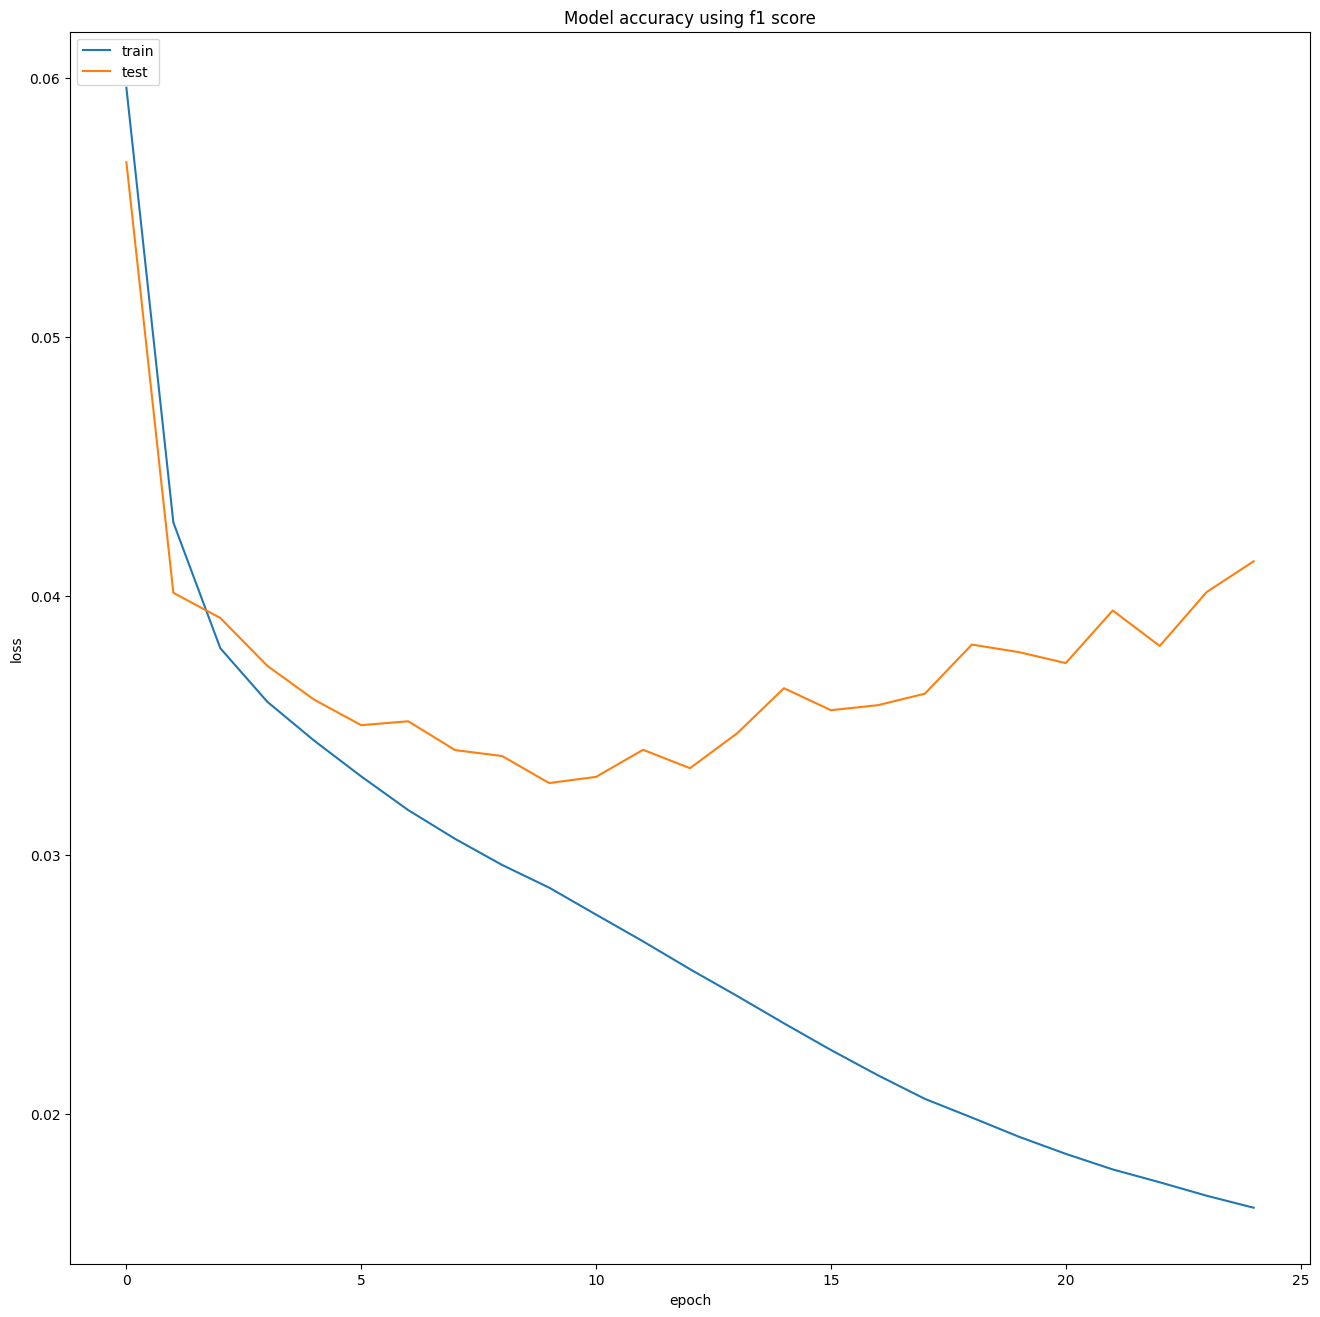

In [521]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(result_moon.history['loss'])
plt.plot(result_moon.history['val_loss'])
plt.title('Model accuracy using f1 score')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(result_moon.history['loss'])
plt.plot(result_moon.history['val_loss'])
plt.title('Model accuracy using f1 score')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [522]:
model_moon.save("/workspace/code/models/moon_hillshade.h5")

## Fine tune the moon model on hunting pits

In [537]:
import keras
from keras.models import Model
reconstructed_model = keras.models.load_model("/workspace/code/models/moon_hillshade.h5")# load old model
#reconstructed_model = keras.models.load_model("/workspace/code/models/moon_minimal_curvature.h5")# load old model


reconstructed_model.compile(
    tf.keras.optimizers.Adam(learning_rate=0.0001),
                            loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, from_logits=True),
                            metrics=['acc', f1_m, recall_m])

In [538]:
result_pretrained = reconstructed_model.fit(train_batches_pit.map(add_sample_weights),validation_data=test_batches_pit, epochs=100, steps_per_epoch=83)
#result_pretrained = reconstructed_model.fit(train_batches_pit,validation_data=test_batches_pit, epochs=100, steps_per_epoch=83)

Epoch 1/100
83/83 [==============================] - 8s 83ms/step - loss: 0.0017 - acc: 0.9822 - f1_m: 0.2729 - recall_m: 0.5768 - val_loss: 0.0419 - val_acc: 0.9862 - val_f1_m: 0.3729 - val_recall_m: 0.7442
Epoch 2/100
83/83 [==============================] - 7s 80ms/step - loss: 7.3774e-04 - acc: 0.9882 - f1_m: 0.4245 - recall_m: 0.7819 - val_loss: 0.0351 - val_acc: 0.9860 - val_f1_m: 0.3984 - val_recall_m: 0.8348
Epoch 3/100
83/83 [==============================] - 7s 80ms/step - loss: 5.8773e-04 - acc: 0.9893 - f1_m: 0.4636 - recall_m: 0.8338 - val_loss: 0.0263 - val_acc: 0.9885 - val_f1_m: 0.4508 - val_recall_m: 0.8503
Epoch 4/100
83/83 [==============================] - 7s 80ms/step - loss: 4.8810e-04 - acc: 0.9896 - f1_m: 0.4789 - recall_m: 0.8588 - val_loss: 0.0220 - val_acc: 0.9887 - val_f1_m: 0.4555 - val_recall_m: 0.8585
Epoch 5/100
83/83 [==============================] - 7s 81ms/step - loss: 4.1265e-04 - acc: 0.9897 - f1_m: 0.4877 - recall_m: 0.8819 - val_loss: 0.0217 - va

In [539]:
results_pretrained = reconstructed_model.evaluate(test_batches_pit)

21/21 [==============================] - 0s 20ms/step - loss: 0.0079 - acc: 0.9937 - f1_m: 0.5956 - recall_m: 0.8358


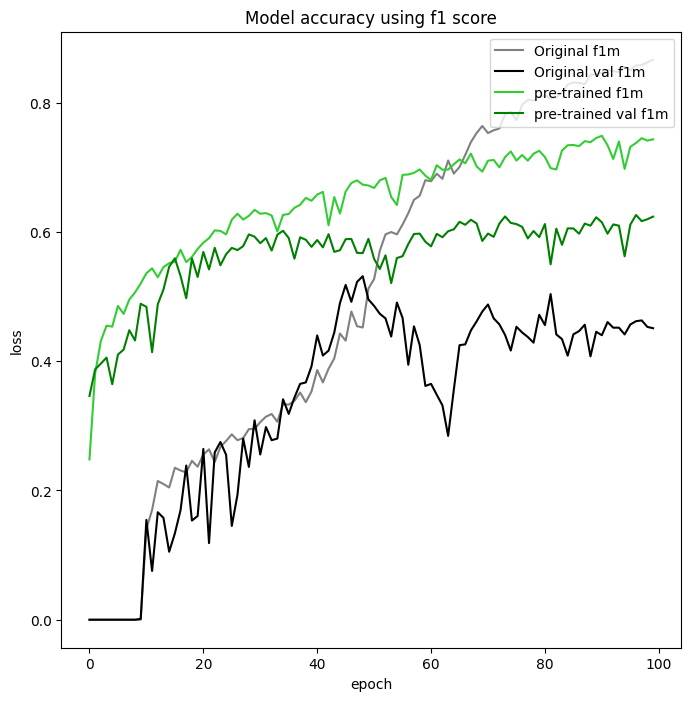

In [478]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]
plt.plot(result0.history['f1_m'],color="grey")
plt.plot(result0.history['val_f1_m'],color="black")
plt.plot(result_pretrained.history['f1_m'],color="limegreen")
plt.plot(result_pretrained.history['val_f1_m'],color="green")


plt.title('Model accuracy using f1 score')
#

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Original f1m','Original val f1m', 'pre-trained f1m','pre-trained val f1m'], loc='upper right')
#plt.ylim(0,1)
#plt.xlim(0,200)
plt.show()

1/1 [==============================] - 0s 136ms/step


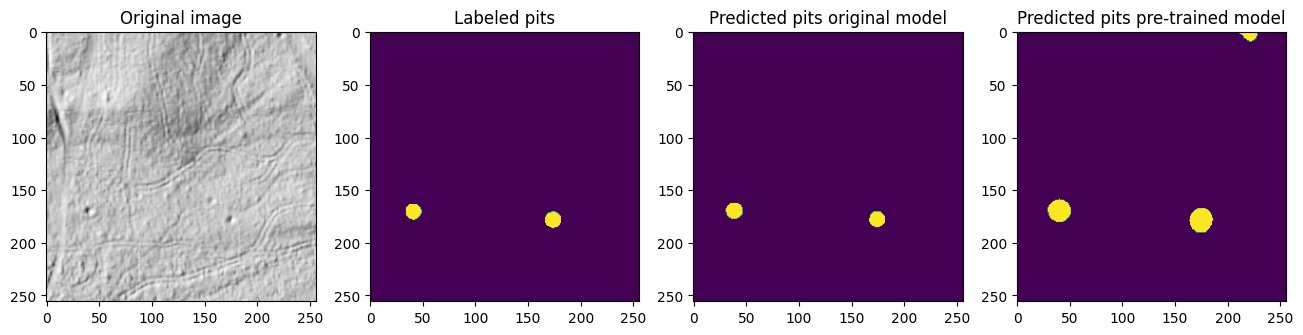

In [481]:
# size of plot
import numpy as np
import random
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.figsize'] = [16, 16]
f, axarr = plt.subplots(1,4)
i = random.randint(0, 300)
#i = 14
#i = 107
testimage = X_test_pit[i]
orgimage = np.squeeze(testimage)

# label
testlabel = Y_test_pit[i]
testlabel = np.squeeze(testlabel)

# prediction from original model
testimage = X_test_pit[i]
testimage = np.reshape(testimage,[1,256,256,1])
prediction1 = model_pit.predict(testimage)
pred1 = np.squeeze(prediction1)

# prediction
prediction2 = reconstructed_model.predict(testimage)
pred2 = np.squeeze(prediction2)


# Image
axarr[0].set_title('Original image')
axarr[0].imshow(orgimage, cmap='Greys_r')

# Label
axarr[1].set_title('Labeled pits')
axarr[1].imshow(testlabel)

# Prediction
axarr[2].set_title('Predicted pits original model')
axarr[2].imshow(pred1>0.5)

# Prediction
axarr[3].set_title('Predicted pits pre-trained model')
axarr[3].imshow(pred2>0.5)

In [212]:
i

107

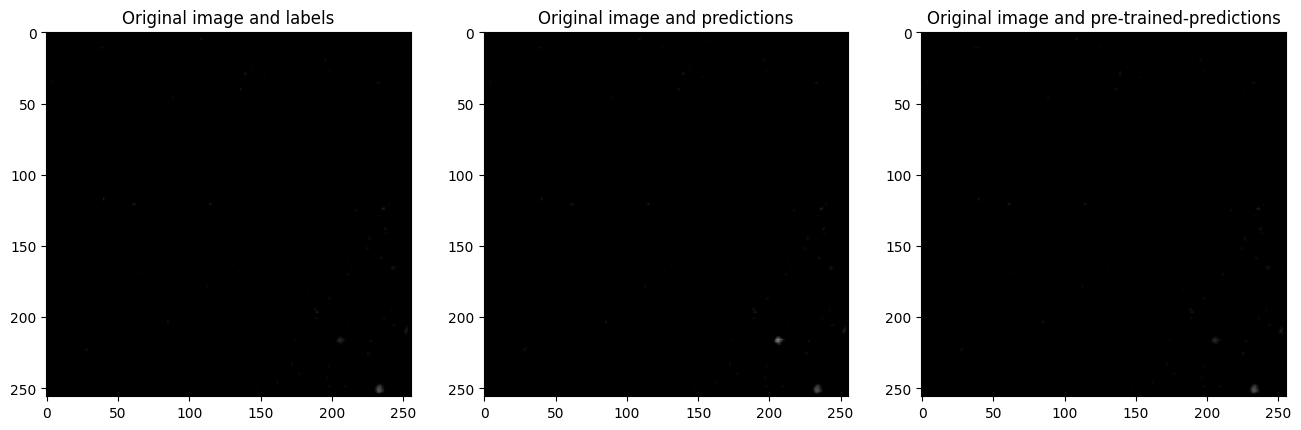

In [465]:
from matplotlib import colors
comap = colors.ListedColormap(['black'])

plt.rcParams['figure.figsize'] = [16, 16]
f, axarr = plt.subplots(1,3)

axarr[0].set_title('Original image and labels')
axarr[0].imshow(orgimage, cmap='Greys_r')
testlabel = np.ma.masked_where(testlabel < 0.5, testlabel)
axarr[0].imshow(testlabel, alpha=0.7,cmap=comap)

axarr[1].set_title('Original image and predictions')
pred1 = np.ma.masked_where(pred1 < 0.5, pred1)
axarr[1].imshow(orgimage, cmap='Greys_r')
axarr[1].imshow((pred1>0.5), alpha=0.7, cmap=comap)


axarr[2].set_title('Original image and pre-trained-predictions')
axarr[2].imshow(orgimage, cmap='Greys_r')

pred2 = np.ma.masked_where(pred2 < 0.5, pred2)
axarr[2].imshow(orgimage, cmap='Greys_r')
axarr[2].imshow(pred2, alpha=0.7, cmap=comap)# = np.ma.masked_where(pred2 < 0.5, pred2))


In [165]:
!python /workspace/code/semantic_segmentation/inference_unet.py -I /workspace/data/demo_area/topographical_indicies/hillshade /workspace/code/models/transfer_hillshade.h5 /workspace/data/demo_area/inference/inference_hillshade_pretrained

2023-05-08 17:36:30.895817: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 17:36:33.207977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-08 17:36:33.210221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-08 17:36:33.210372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning

In [173]:
!python inference.py /workspace/data/demo_area/topographical_indicies/hillshade, /workspace/code/models/transfer_hillshade.h5, /workspace/data/demo_area/inference/inference_hillshade_pretrained

1/1 [==============================] - 0s 154ms/step


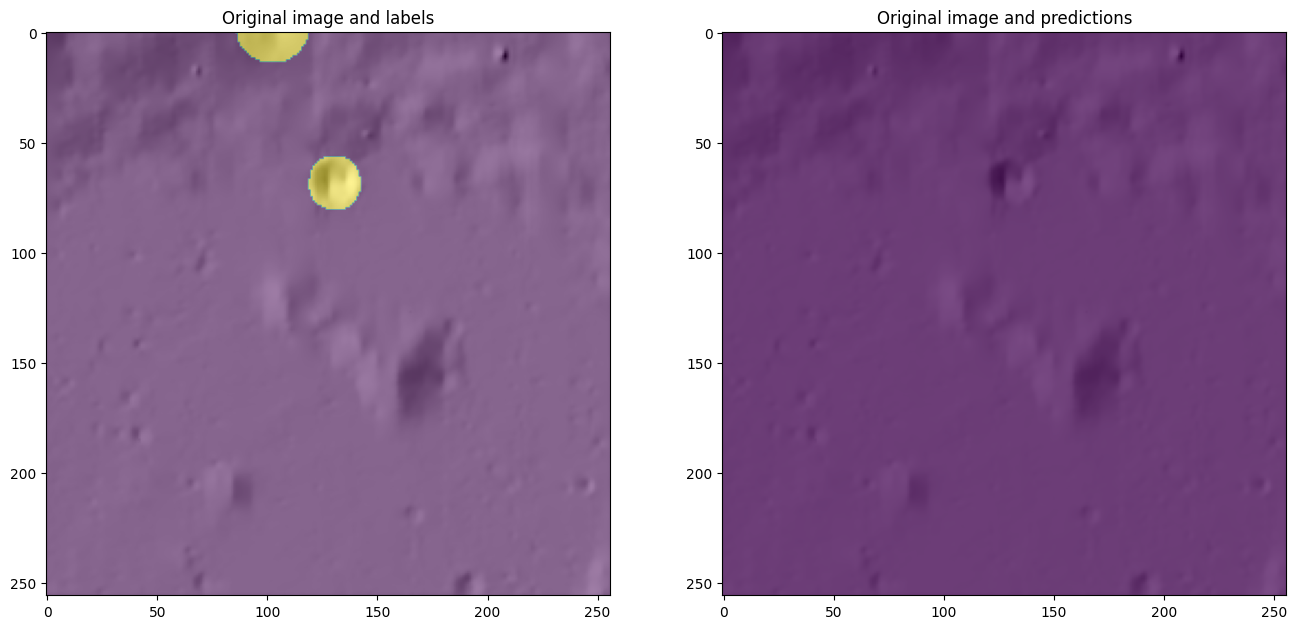

In [383]:
plt.rcParams['figure.figsize'] = [16, 16]
f, axarr = plt.subplots(1,2)



#image 
testimage = X_test[i]
orgimage = np.squeeze(testimage)


testimage = X_test[i]
testimage = np.reshape(testimage,[1,256,256,1])
prediction = reconstructed_model.predict(testimage)
pred = np.squeeze(prediction)

# label
testlabel = Y_test[i]
testlabel = np.squeeze(testlabel)
axarr[0].set_title('Original image and labels')
axarr[0].imshow(orgimage, cmap='Greys_r')
axarr[0].imshow(testlabel, alpha=0.5)

axarr[1].set_title('Original image and predictions')
axarr[1].imshow(orgimage, cmap='Greys_r')
axarr[1].imshow((pred>0.5), alpha=0.7)